In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm

import cv2
import tifffile as tf


In [2]:
import py3utils as p3
import rf_utils as rfutils
import plotting as pplot
import roi_utils as rutils
import gratings_utils as gutils

In [3]:
%matplotlib notebook

# Source

In [15]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

traceid = 'traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20

# Plotting

In [7]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Aggregate meta 

In [8]:
sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,11,11,11
V1,9,9,9


In [13]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Output dir

In [442]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


#### Test 1 animal

In [31]:
va='V1'
dk='20190617_JC097_fov1'

ori_dir = gutils.get_ori_dir(dk, traceid=traceid, fit_desc=ori_fit_desc)
print(ori_dir)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e3c1f2_traces001_467d9f_traces001_88209d_traces001_359554/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [38]:
# from class Gratings.get_tuning()
# Gets ori_fit_desc
# Loads tuning results (bootstrapped)
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)

g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)
        

In [71]:
# Get fits
best_fits, all_fits = gutils.get_good_fits(boot_, fitparams, 
                                                 gof_thr=None, verbose=False)
# if rmetrics is None:
#     no_fits.append('%s_%s' % (va, dk))
#     continue

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/gratings_utils.py:162: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [93]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, fit_desc=ori_fit_desc,
                             return_missing=True) 


In [102]:
gdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,15
Lm,10
V1,9


In [100]:
missing_

['Lm_20191111_JC120_fov1']

In [278]:
# va='V1'
# dk='20190617_JC097_fov1'
# zimg, masks, centroids = rutils.get_masks_and_centroids(dk)

In [1102]:
gdata = p3.split_datakey(gdata)
gdata = gdata[~gdata.animalid.isin(old_rats)].copy()

In [1103]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
        .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,datakey,animalid,fov,session
visual_area,,,,,,,,,,,,,,,,,,
Li,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216
Lm,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505,505
V1,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686


In [1104]:
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = list(tested_thetas.copy())
theta_vals.append(360)
theta_vals = np.array(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref']]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

# Aggregate metrics

In [1105]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


visual_area
Li     75
Lm    249
V1    341
Name: cell, dtype: int64


<IPython.core.display.Javascript object>


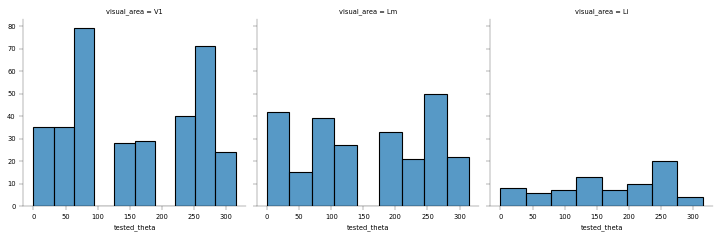

In [1106]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
print(passg.groupby(['visual_area'])['cell'].count())
fg = sns.FacetGrid(passg, col='visual_area', col_order=visual_areas, height=3)
fg.map(sns.histplot, 'tested_theta')

In [1107]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

<IPython.core.display.Javascript object>


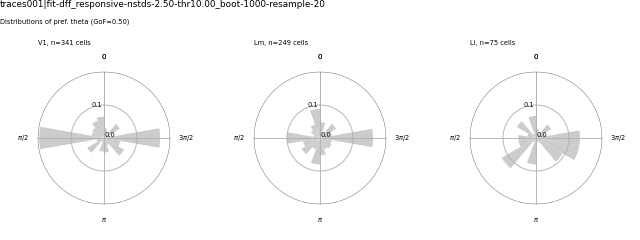

0.0 5.497787143782138
0.0 5.497787143782138
0.0 5.497787143782138
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_pref_noold_gof0.50


In [1109]:
metric = 'theta_pref'
bin_size = 20
ai = 1
col='k'
fontsize=6

fig = pl.figure(figsize=(8,3))
for va, vg in passg.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    degrees = vg[metric].values
    radians = np.array([np.deg2rad(v) for v in degrees])
    print(thetas.min(), thetas.max())
    cmean = spstats.circmean(thetas, nan_policy='omit')
    
    weights = np.ones_like(degrees)/len(degrees)
    a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                        weights=weights)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    ax.bar(centers, a, width=np.deg2rad(bin_size), 
                   bottom=0.0, color='.8', edgecolor='none')
#     # bin data for our polar histogram
#     counts, t_bins = np.histogram(thetas, bins=bins)
#     # Normalise counts to compute areas
#     area = counts / thetas.size
#     # Compute corresponding radii from areas
#     radius = (area / np.pi)**.5
#     ax.bar(t_bins[:-1], radius, align='edge', color=col, alpha=0.2)
    # plot mean
    # ax.plot([0, cmean], [0, max(radius)], color=col, lw=0.5)
    # Label angles according to convention
    ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'],
                      fontsize=fontsize)
    ax.set_title('%s, n=%i cells' % (va, len(vg)), loc='left', fontsize=fontsize)
    ax.set_theta_zero_location("N")
    ax.set_ylim([0, 0.2])
    ax.set_yticks(np.linspace(0, 0.1, 2))
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of pref. theta (GoF=%.2f)' % gof_thr)
p3.label_figure(fig, data_id)

figname = 'polar_%s_noold_gof%.2f' % (metric, gof_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [1110]:

passg.groupby(['visual_area', 'datakey']).count()

asi  dsi  response_null  response_offset  \
visual_area datakey                                                         
Li          20190522_JC089_fov1    5    5              5                5   
            20190602_JC091_fov1   20   20             20               20   
            20190606_JC091_fov1    6    6              6                6   
            20190607_JC091_fov1   12   12             12               12   
            20190609_JC099_fov1    4    4              4                4   
            20190612_JC099_fov1    5    5              5                5   
            20190614_JC091_fov1   12   12             12               12   
            20190617_JC099_fov1    3    3              3                3   
            20191018_JC113_fov1    6    6              6                6   
            20191105_JC117_fov1    1    1              1                1   
            20191111_JC120_fov1    1    1              1                1   
Lm          20190512_JC083_fov1   10   10             10               10   
            20190513_JC078_fov1  121  121            121              121   
            20190517_JC083_fov1    5    5              5                5   
            20190525_JC084_fov1   33   33             33               33   
            20190603_JC080_fov1   44   44             44               44   
            20190618_JC097_fov1   14   14             14               14   
            20190627_JC091_fov1   20   20             20               20   
            20191105_JC117_fov1    2    2              2                2   
V1          20190511_JC083_fov1   77   77             77               77   
            20190512_JC083_fov1    3    3              3                3   
            20190517_JC083_fov1    1    1              1                1   
            20190522_JC084_fov1   73   73             73               73   
            20190613_JC097_fov1   34   34             34               34   
            20190616_JC097_fov1   44   44             44               44   
            20190617_JC097_fov1   34   34             34               34   
            20190622_JC085_fov1   54   54             54               54   
            20191006_JC110_fov1   21   21             21               21   

                                 response_pref  sigma  theta_pref   r2  cell  \
visual_area datakey                                                            
Li          20190522_JC089_fov1              5      5           5    5     5   
            20190602_JC091_fov1             20     20          20   20    20   
            20190606_JC091_fov1              6      6           6    6     6   
            20190607_JC091_fov1             12     12          12   12    12   
            20190609_JC099_fov1              4      4           4    4     4   
            20190612_JC099_fov1              5      5           5    5     5   
            20190614_JC091_fov1             12     12          12   12    12   
            20190617_JC099_fov1              3      3           3    3     3   
            20191018_JC113_fov1              6      6           6    6     6   
            20191105_JC117_fov1              1      1           1    1     1   
            20191111_JC120_fov1              1      1           1    1     1   
Lm          20190512_JC083_fov1             10     10          10   10    10   
            20190513_JC078_fov1            121    121         121  121   121   
            20190517_JC083_fov1              5      5           5    5     5   
            20190525_JC084_fov1             33     33          33   33    33   
            20190603_JC080_fov1             44     44          44   44    44   
            20190618_JC097_fov1             14     14          14   14    14   
            20190627_JC091_fov1             20     20          20   20    20   
            20191105_JC117_fov1              2      2           2    2     2   
V1          20190511_JC083_fov1           

# Salt N Pepper

In [1168]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples


In [1142]:
va='V1'
# dk='20190511_JC083_fov1'
# dk='20190616_JC097_fov1'
dk='20190522_JC084_fov1'

curr_data_id = '%s\n%s_%s' % (data_id, dk, va) #
print(curr_data_id)

zimg, masks, centroids = rutils.get_masks_and_centroids(dk)

# Check masks/centroids
# summed = masks.sum(axis=0)
# fig, ax =pl.subplots()
# ax.imshow(zimg, cmap='gray')
# ax.imshow(summed, cmap='Reds', alpha=0.5)
# sns.scatterplot(x='y', y='x', s=5, data=centroids, ax=ax)


traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
20190522_JC084_fov1_V1


In [1143]:
sdf = p3.get_stimuli(dk, 'gratings')
tested_thetas = sorted(np.array(sdf['ori'].unique().astype(float)))
print(dk, tested_thetas)
sdf.head()

20190522_JC084_fov1 [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]


,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config007,0,None,gratings,20.0,-8.0,1,0,"(20, -8)",10,0.5,20.0
config006,0,None,gratings,20.0,-8.0,1,0,"(20, -8)",20,0.1,20.0
config005,0,None,gratings,20.0,-8.0,1,0,"(20, -8)",10,0.1,20.0
config004,0,None,gratings,0.0,0.0,1,0,"(0, 0)",20,0.5,200.0
config003,0,None,gratings,0.0,0.0,1,0,"(0, 0)",10,0.5,200.0


8


<IPython.core.display.Javascript object>


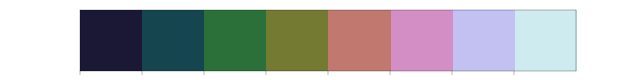

In [1144]:
# Assign color vals
#from matplotlib.colors import ListedColormap
colormap = 'cubehelix'
print(len(tested_thetas))
ori_colors = sns.color_palette(colormap, n_colors=len(tested_thetas))
cmap = mpl.colors.ListedColormap(colors=ori_colors)
sns.palplot(ori_colors)


In [1175]:
gof_thr=0#-10000
passg = bestg[bestg['gof']>=gof_thr].copy()

In [1176]:
currg = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()
rois_ = sorted(currg['cell'].unique())
print("%i cells pass (gof=%.2f)" % (len(rois_), gof_thr))
currg.index=rois_
df_ = pd.concat([centroids.loc[rois_], currg], axis=1)
df_.shape

107 cells pass (gof=0.00)


(107, 22)

In [1220]:
sorted_cells = df_.sort_values(by=['response_pref', 'gof', 'r2comb'], \
                               ascending=False)['cell'].values
sorted_cells[0:10]
plot_rois = list(sorted_cells[0:10])
print(plot_rois)

[163.0, 135.0, 234.0, 211.0, 203.0, 222.0, 227.0, 69.0, 137.0, 54.0]


<IPython.core.display.Javascript object>


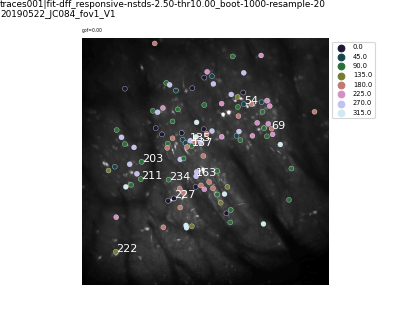

<IPython.core.display.Javascript object>


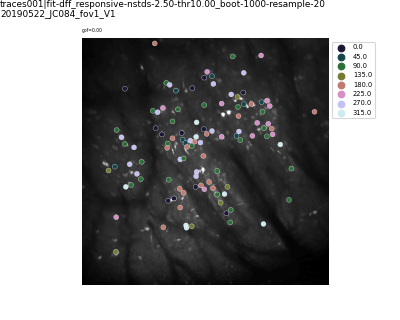

In [1185]:
#highlight_rois = [27, 119, 153]
#plot_rois.extend(highlight_rois)

for label_rois in [True, False]:
    fig, ax =pl.subplots()
    ax.imshow(zimg, cmap='gray')
    sns.scatterplot(x='y', y='x', data=df_, ax=ax,
                    hue='tested_theta', palette=ori_colors, 
                    s=20,linewidth=0.25)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.axis('off')
    if label_rois is True:
        for rid in plot_rois:
            ax.text(df_.loc[rid]['y'], df_.loc[rid]['x'], int(rid), 
                    fontsize=10, color='w')
    ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')

    pplot.label_figure(fig, curr_data_id)
    figname='saltpepper_%s_%s' % (va, dk) 
    if label_rois:
        figname='%s_labeled' % figname
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [1181]:
gof_thr

0

<IPython.core.display.Javascript object>


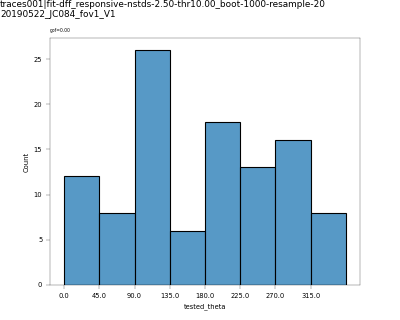

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples preftheta_histbar_V1_20190522_JC084_fov1


In [1182]:
fig, ax = pl.subplots()
sns.histplot(x='tested_theta', data=df_, ax=ax, bins=np.arange(0, 360+45, 45))
ax.set_xticks(tested_thetas) #np.arange(0, len(tested_thetas)))
ax.set_xticklabels(tested_thetas)
ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')

pplot.label_figure(fig, curr_data_id)
figname='preftheta_histbar_%s_%s' % (va, dk) 
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [235]:
np.linspace(0, 360, 9)

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

In [1214]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

In [1186]:
session, animalid, fovnum = p3.split_datakey_str(dk)
print(session, animalid, fovnum)

20190522 JC084 1


In [1195]:
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)

g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)
        

In [1190]:
dff_traces, labels, sdf = p3.load_traces(animalid, session, fovnum, experiment, 
                traceid=traceid, response_type=response_type,
                responsive_test=responsive_test, responsive_thr=responsive_thr,
                n_stds=n_stds)
dff_traces.head()

,0,5,9,11,12,14,16,17,19,25,...,234,235,236,237,241,242,246,247,255,258
0,0.005790,0.124601,0.002818,0.106033,-0.091157,-0.209670,-0.140721,-0.137224,0.008941,0.047764,...,0.019495,-0.081801,0.041154,-0.095522,-0.146196,0.023852,-0.090581,0.135503,0.095296,-0.044996
1,0.013237,-0.053035,0.043592,-0.006306,-0.004726,-0.007317,0.072777,0.070566,-0.059611,-0.096955,...,-0.093062,-0.007330,0.063645,0.050938,-0.064349,0.018378,-0.004542,-0.016379,-0.005833,-0.013060
2,-0.005487,0.038270,-0.091972,-0.133544,-0.035198,0.041557,0.004898,0.013917,0.031834,0.101324,...,-0.057173,-0.073409,-0.005662,0.002420,0.004654,0.103204,-0.090045,0.202657,-0.038086,-0.147837
3,-0.033418,-0.013357,-0.151042,0.069673,0.024244,0.302355,0.170737,0.051839,0.054692,0.107211,...,0.027738,-0.118121,-0.030838,-0.070964,0.147839,-0.019438,0.055344,-0.076296,0.042821,0.032106
4,-0.029921,-0.002120,-0.012625,0.037398,0.054968,-0.036790,0.093877,-0.140463,-0.040389,-0.004703,...,-0.199347,-0.006827,-0.080045,-0.045181,-0.090727,-0.089642,0.056380,0.015822,0.081926,0.095206


In [1192]:
df_['response_pref'].max()

0.19805558511183563

In [1193]:
windowsz = 9
smooth_traces = True
plot_trials = True

ymax = 0.2
min_val, max_val = 0, 0

trace_color = 'k'

transform_param = 'ori'
transform_values = sorted(sdf[transform_param].unique())

In [1208]:
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]

ori_colors = sns.color_palette(palette='cubehelix', n_colors=len(transform_values))
print(transform_values)

[0, 45, 90, 135, 180, 225, 270, 315]


In [1223]:
boot_.keys()

dict_keys([0, 5, 9, 11, 12, 14, 16, 17, 19, 25, 30, 33, 40, 44, 45, 49, 51, 52, 54, 55, 56, 57, 59, 61, 65, 66, 67, 68, 69, 70, 73, 75, 78, 86, 88, 91, 92, 93, 97, 98, 102, 106, 107, 114, 115, 116, 119, 121, 122, 123, 124, 125, 126, 128, 132, 134, 135, 136, 137, 138, 139, 142, 143, 144, 147, 148, 150, 151, 153, 154, 155, 156, 160, 161, 163, 165, 166, 168, 173, 175, 176, 177, 178, 179, 189, 193, 194, 195, 196, 203, 205, 206, 210, 211, 212, 215, 216, 217, 220, 222, 225, 227, 228, 231, 232, 234, 235, 236, 237, 241, 242, 246, 247, 255, 258])

In [1233]:
rid=30
boot_[rid].keys()

dict_keys([(0.1, 20.0, 20.0), (0.1, 20.0, 10.0), (0.5, 20.0, 10.0)])

<IPython.core.display.Javascript object>


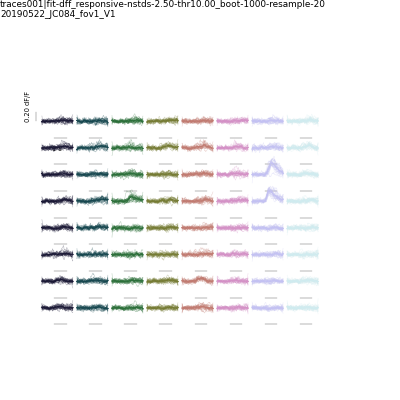

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples traces_rid30_V1_20190522_JC084_fov1


In [1234]:
fig, axes = pl.subplots(len(cfg_values), len(transform_values), 
                        figsize=(5,5), sharex=False, sharey=True)

for ci, cfgv in enumerate(cfg_values):
    condkey = cfgv #tuple([float(i) for i in cfgv.split('-')[1::2]])
    if condkey not in list(boot_[rid].keys()):
        currcfgs = sdf[(sdf['sf']==condkey[0]) & (sdf['size']==condkey[1]) & (sdf['speed']==condkey[2])].index.tolist()
    else:
        currcfgs = boot_[rid][condkey]['stimulus_configs']
    currlabels = labels[labels['config'].isin(currcfgs)]
    si = cfg_values.index(condkey)
    #currcolor = colors[si]

    for col, (cfg, g) in zip(colors, currlabels.groupby(['config'])):
        currv = sdf[transform_param][cfg] #.copy()
        plot_ix = transform_values.index(currv)
        ax = axes[plot_ix] if len(cfg_values)==1 else axes[ci, plot_ix]
        ax.patch.set(alpha=0)
        if plot_trials:
            for trial, tdf in g.groupby(['trial']):
                tsec = tdf['tsec'].values
                tvals = dff_traces[rid][tdf.index].values
                st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
                sm = temporal_downsample(tvals, windowsz) if smooth_traces else tvals
                ax.plot(st, sm, color=col, alpha=0.3, lw=0.5)

                max_val = max([max_val, (sm).max() ])
                min_val = min( [min_val, (sm).min()])

            meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
            ax.plot(tsec, sm, color=col, alpha=1, lw=1)

        else:
            tsec =  np.nanmean(np.vstack(g.groupby(['trial'])['tsec'].apply(np.array).values), axis=0).astype(float)
            meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            semtrace = spstats.sem(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0, nan_policy='omit')

            st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
            sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
            ss = temporal_downsample(semtrace, windowsz) if smooth_traces else semtrace

            ax.plot(st, sm, color=col)
            ax.fill_between(st, sm+ss, sm-ss, color=col, alpha=0.2)
            ax.plot([0, 0], [1, 0], 'k', lw=2)
            ax.set_xticklabels([''])
            max_val = max([max_val, (sm+ss).max() ])
            min_val = min( [min_val, (sm-ss).min()])

for ai, ax in enumerate(axes.flat):
    ax.set_ylim([min_val, max_val])
    ax.tick_params(which='both', axis='both', length=0)
    if ai == 0:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['', ''])
        ax.set_xlabel('1 s')
        ax.set_yticks([0, ymax])
        ax.set_yticklabels(['', ''])
        ax.set_ylabel('%.2f dF/F' % ymax)
        sns.despine(trim=True, ax=ax, offset=4)
    else:
        #ax.set_yticklabels([''])
        ax.set_yticks([]) 
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['', ''])
        sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=False)
        
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.8,hspace=-.5, wspace=0.01)

pplot.label_figure(fig, curr_data_id)
figname='traces_rid%i_%s_%s' % (rid, va, dk) 
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [1212]:
sdf[transform_param][cfg]

0

In [533]:
def calculate_signal_correlations(tuning_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate signal corrs
    corrs_ = {}
    rois_ = [i for i in tuning_.columns if p3.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for col_a, col_b in itertools.combinations(rois_, 2):
        corrs_['%i__%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], tuning_[col_b])
    sigcorrs = pd.DataFrame.from_dict(corrs_, orient='index')
    sigcorrs.columns = ['PCC', 'p-value']
    sigcorrs['cell_1'] = [int(r.split('__')[0]) for r in sigcorrs.index]
    sigcorrs['cell_2'] = [int(r.split('__')[1]) for r in sigcorrs.index]
    
    return sigcorrs

In [506]:
# dpath = p3.aggregate_and_save(experiment, traceid=traceid,
#                       response_type=response_type, epoch=trial_epoch,
#                       responsive_test=responsive_test, 
#                       responsive_thr=responsive_thr, n_stds=responsive_thr)


In [552]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [553]:
NDATA[NDATA.visual_area=='Li']['datakey'].unique()

array(['20190314_JC070_fov1', '20190315_JC070_fov2',
       '20190319_JC067_fov1', '20190522_JC089_fov1',
       '20190527_JC092_fov3', '20190602_JC091_fov1',
       '20190606_JC091_fov1', '20190607_JC091_fov1',
       '20190609_JC099_fov1', '20190612_JC099_fov1',
       '20190614_JC091_fov1', '20190617_JC099_fov1',
       '20191018_JC113_fov1', '20191105_JC117_fov1',
       '20191111_JC120_fov1'], dtype=object)

In [514]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [526]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [659]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [603]:
va='V1'
dk = '20190511_JC083_fov1'

In [604]:
session, animalid, fovn = p3.split_datakey_str(dk)
print(session, animalid)
ndf=NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()


20190511 JC083


In [605]:
sdf = fullSDF[dk].copy()
cfgs = sdf.index.tolist()
ndf = ndf[(ndf.config.isin(cfgs))]
# Reshape dataframe to ntrials x nrois
trial_means = p3.stacked_neuraldf_to_unstacked(ndf)

In [606]:
# Zscore trials
cfgs_by_trial = trial_means['config']
zscored = p3.zscore_dataframe(trial_means)
zscored['config'] = cfgs_by_trial
# Get mean reposnse per condition
tuning_ = zscored.groupby(['config']).mean().reset_index()
sigcorrs = calculate_signal_correlations(tuning_)

<IPython.core.display.Javascript object>


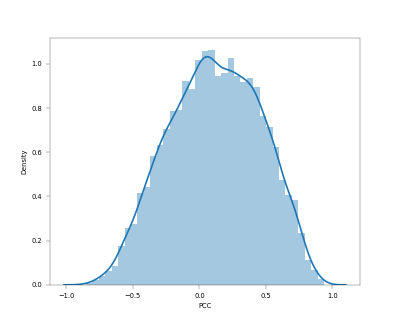

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PCC', ylabel='Density'>

In [607]:
pl.figure()
sns.distplot(sigcorrs['PCC'])

### Signal corrs

In [930]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


In [692]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [693]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)

# Get ROI positions
posdf = p3.add_rf_positions(posdf)

Adding RF position info...


In [599]:
posdf.shape, posdf.dropna().shape

((1875, 13), (1875, 13))

In [987]:
selective_only=True
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

gof0.50


In [988]:
c_ = []
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = ndf['cell'].unique()
    if len(rois_)<2:
        continue
    if dk not in SD.keys():
        continue
    sdf = SD[dk].copy()
    cfgs = sdf.index.tolist()
    if len(cfgs)==0:
        continue
    ndf = ndf[(ndf.config.isin(cfgs))]
    # Reshape dataframe to ntrials x nrois
    trial_means0 = p3.stacked_neuraldf_to_unstacked(ndf)
    # Zscore trials
    cfgs_by_trial = trial_means0['config']
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) & (passg.datakey==dk)]['cell'].unique()
        if len(curr_cells)<5:
            continue
    else:
        curr_cells = rois_
    trial_means = trial_means0[curr_cells].copy()
    zscored = p3.zscore_dataframe(trial_means)
    zscored['config'] = cfgs_by_trial
    # Get mean reposnse per condition
    tuning_ = zscored.groupby(['config']).mean().reset_index()
    sigcorrs = calculate_signal_correlations(tuning_)
    # Get current FOV rfdata and add position info to sigcorrs df
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[sigcorrs['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[sigcorrs['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    sigcorrs['cortical_distance'] = dists
    sigcorrs['visual_area'] = va
    sigcorrs['datakey'] = dk
    c_.append(sigcorrs)
signal_corrs = pd.concat(c_, axis=0).reset_index(drop=True)


In [999]:
# Bin cortical distances for plotting
n_bins_dist = 10
n_bins_overlap = 8
use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    signal_corrs['binned_dist'], bin_edges = pd.qcut(signal_corrs['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    signal_corrs['binned_dist'], bin_edges = pd.cut(signal_corrs['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False

binning: eqwidth10


In [1000]:
min_n_pairs=0
counts_per_bin = signal_corrs.groupby(['visual_area', 'datakey', 'binned_dist'])\
                    ['PCC'].count().reset_index()
pass_keys = [(va, dk) for (va, dk), g in \
             counts_per_bin[counts_per_bin['PCC']>=min_n_pairs].groupby(['visual_area', 'datakey'])]
CC = pd.concat([g for (va, dk), g in signal_corrs.groupby(['visual_area', 'datakey']) \
               if (va, dk) in pass_keys])
CC.shape, signal_corrs.shape

((19378, 8), (19378, 8))

In [1001]:
mean_ccs = CC.groupby(['visual_area', 'datakey', 'binned_dist']).mean().reset_index()

<IPython.core.display.Javascript object>


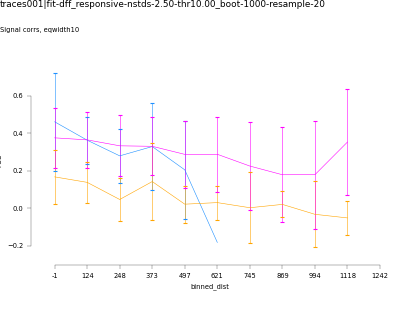

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics sigcorrs_by_dist__allstim_gof0.50


In [1002]:
metric='PCC'
fig, ax = pl.subplots( figsize=(5,4)) #, sharex=True, sharey=False)
sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, 
             ci='sd', err_style='bars', 
            err_kws={'capsize':2, 'lw': lw}, lw=lw)
ax.set_xticks(list(range(len(bin_edges))))
ax.set_xticklabels([round(i) for i in bin_edges])
#ax.set_ylim([0, 0.5])
sns.despine(offset=8, trim=True, ax=ax)
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal corrs, %s' % bin_type)
figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## ASI/DSI

In [1003]:
def combine_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='asi']
    sd1 = scatdf[all_cols].copy().rename(columns={'dsi': 'value'})
    sd1['ori_metric'] = 'dsi'

    all_cols = [k for k in scatdf.columns if k!='dsi']
    sd2 = scatdf[all_cols].copy().rename(columns={'asi': 'value'})
    sd2['ori_metric'] = 'asi'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd

In [1062]:
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
bestg = p3.split_datakey(bestg)
bestg = bestg[~bestg.animalid.isin(old_rats)]
bestg[bestg.visual_area=='Li']['datakey']

46     20190522_JC089_fov1
48     20190522_JC089_fov1
50     20190522_JC089_fov1
52     20190522_JC089_fov1
55     20190522_JC089_fov1
              ...         
481    20191018_JC113_fov1
482    20191018_JC113_fov1
484    20191105_JC117_fov1
488    20191105_JC117_fov1
490    20191111_JC120_fov1
Name: datakey, Length: 216, dtype: object

In [1063]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
combog = combine_metrics(passg)


<IPython.core.display.Javascript object>


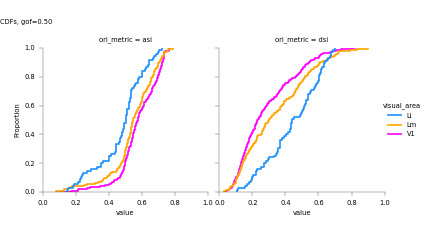

In [1064]:
fg = sns.displot(combog, col='ori_metric', col_order=['asi', 'dsi'],
            x='value', hue='visual_area', palette=area_colors, height=3,
           kind='ecdf', aspect=0.8)
for ax in fg.axes.flat:
    ax.set_xlim([0, 1])
fg.fig.text(0.0, 0.9, 'CDFs, gof=%.2f' % gof_thr)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'ASI_DSI_gof%.2f_cdf' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

In [1015]:
gof_thr

0.5

In [1016]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

In [1065]:
combog = combine_metrics(passg)

curr_counts = combog.groupby(['visual_area', 'datakey']).count().reset_index()
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
finaldf = pd.concat([g for (va, dk), g in combog.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

[Li] Animalid does not exist: 2 
[Li] Animalid does not exist: 6 
[Li] Animalid does not exist: 8 
[Li] Animalid does not exist: 10 
[Li] Animalid does not exist: 12 
[Li] Animalid does not exist: 24 
[Li] Animalid does not exist: 40 
[Lm] Animalid does not exist: 4 
[Lm] Animalid does not exist: 10 
[Lm] Animalid does not exist: 20 
[Lm] Animalid does not exist: 28 
[Lm] Animalid does not exist: 40 
[Lm] Animalid does not exist: 66 
[Lm] Animalid does not exist: 88 
[Lm] Animalid does not exist: 242 
[V1] Animalid does not exist: 2 
[V1] Animalid does not exist: 6 
[V1] Animalid does not exist: 42 
[V1] Animalid does not exist: 68 
[V1] Animalid does not exist: 88 
[V1] Animalid does not exist: 108 
[V1] Animalid does not exist: 146 
[V1] Animalid does not exist: 154 


ValueError: No objects to concatenate

<IPython.core.display.Javascript object>


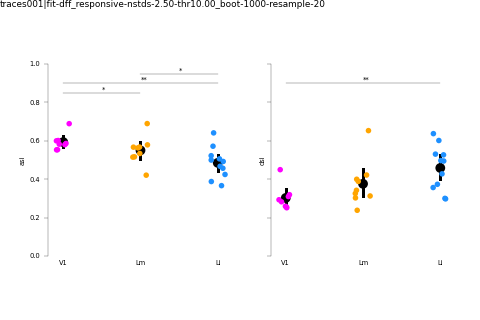

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.030301   16.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li    True  0.030301   24.0   9  11
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.069145   18.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li   False  0.085730   31.0   9  11
****************************


In [1066]:
meang = finaldf.groupby(['visual_area', 'datakey', 'ori_metric']).mean().reset_index()
# fg = sns.FacetGrid(meang, col='ori_metric', col_order=['asi', 'dsi'], 
#               height=3)

# fg.map(sns.stripplot,'visual_area', 'value', 'visual_area', 
#        palette=area_colors)
# fg.map(sns.pointplot,'visual_area', 'value', join=False, color='k')

multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, meang.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,
                 palette=area_colors, hue='visual_area', order=visual_areas)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

# fig.text(0, 0.9, 'ASI & DSI, Means by FOV (gof=%.2f, mc=%s)' % (gof_thr, multi_comp_test))
# figname = 'ASI_DSI_gof%.2f_byFOV' % gof_thr
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, gof_thr)

## Counts

In [1085]:
responsive_ = gdata0.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
responsive_.shape

(29, 3)

In [1086]:
tuned_ = bestg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
tuned_.shape

(29, 3)

In [1087]:
gof_thr=0.25
passg = bestg[bestg['gof']>=gof_thr].copy()

pass_ = passg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
pass_.shape

(29, 3)

In [1088]:
# d_=[]
# for selector, t in zip(['visual', 'fit', 'gof'], [responsive_, tuned_, pass_]):
#     x = t.copy().rename(columns={'cell': selector}).reset_index(drop=True)
#     d_.append(x)
    
responsive0 = responsive_.copy()\
                .rename(columns={'cell': 'visual'}).reset_index(drop=True)

pass0 = pass_.copy()\
                .rename(columns={'cell': 'gof'}).reset_index(drop=True)
responsive0.head()

,visual_area,datakey,visual
0,Li,20190522_JC089_fov1,15
1,Li,20190527_JC092_fov3,7
2,Li,20190602_JC091_fov1,138
3,Li,20190606_JC091_fov1,29
4,Li,20190607_JC091_fov1,67


In [1089]:
pass0[(pass0.visual_area==va) & (pass0.datakey==dk)]

,visual_area,datakey,gof
28,V1,20191006_JC110_fov1,67


In [1090]:
pg

,visual_area,datakey,gof
28,V1,20191006_JC110_fov1,67


In [1091]:
counts = responsive0.copy()
for (va, dk), g in counts.groupby(['visual_area', 'datakey']):
    pg = pass0[(pass0.visual_area==va) & (pass0.datakey==dk)].copy()
    if len(pg)==0:
        ncells = 0
    else:
        ncells = float(pg['gof'])
    counts.loc[g.index, 'gof'] = ncells
    
# counts['gof'] = pass0['gof'].values

In [1092]:
# counts = pd.merge(responsive0, pass0, left_index=True, right_index=True, how='left')
# print(counts.shape)
# counts.head()

In [1093]:
import copy

In [1094]:
min_ncells=10

In [1095]:
counts['gof_over_visual'] = counts['gof']/counts['visual'].astype(float)

In [1096]:
excl = copy.copy(old_rats) #['20190314_JC070_fov1', '20190306_JC061_fov2', '20190314_JC070_fov2']
currd =counts[(counts['visual']>=min_ncells) & ~(counts.datakey.isin(excl))].copy()
currd[currd.visual_area=='Lm']

,visual_area,datakey,visual,gof,gof_over_visual
12,Lm,20190512_JC083_fov1,166,77.0,0.463855
13,Lm,20190513_JC078_fov1,531,172.0,0.323917
14,Lm,20190517_JC083_fov1,20,8.0,0.400000
15,Lm,20190525_JC084_fov1,121,55.0,0.454545
16,Lm,20190603_JC080_fov1,171,77.0,0.450292
17,Lm,20190618_JC097_fov1,62,26.0,0.419355
18,Lm,20190627_JC091_fov1,77,34.0,0.441558


In [1097]:
currd

,visual_area,datakey,visual,gof,gof_over_visual
0,Li,20190522_JC089_fov1,15,7.0,0.466667
2,Li,20190602_JC091_fov1,138,50.0,0.362319
3,Li,20190606_JC091_fov1,29,17.0,0.586207
4,Li,20190607_JC091_fov1,67,26.0,0.388060
5,Li,20190609_JC099_fov1,14,8.0,0.571429
6,Li,20190612_JC099_fov1,42,15.0,0.357143
7,Li,20190614_JC091_fov1,79,30.0,0.379747
8,Li,20190617_JC099_fov1,11,4.0,0.363636
9,Li,20191018_JC113_fov1,36,19.0,0.527778
12,Lm,20190512_JC083_fov1,166,77.0,0.463855


<IPython.core.display.Javascript object>


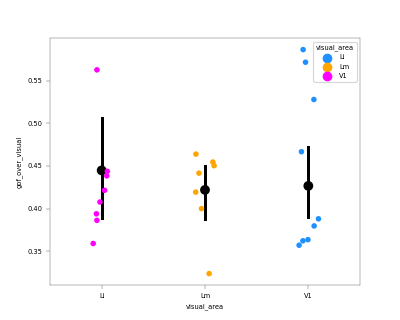

********* [gof_over_visual] Mann-Whitney U test(mc=holm) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.786675   22.0   8   7
1  V1  Li   False  0.915700   35.0   8   9
2  Lm  Li   False  0.915700   30.0   7   9
****************************


(   d1  d2  reject     p_val  U_val  n1  n2
 0  V1  Lm   False  0.786675   22.0   8   7
 1  V1  Li   False  0.915700   35.0   8   9
 2  Lm  Li   False  0.915700   30.0   7   9,
 <AxesSubplot:xlabel='visual_area', ylabel='gof_over_visual'>)

In [1101]:

fig, ax = pl.subplots()
#sns.barplot(x='visual_area', y='fraction_gof_over_visual', data=currd, ax=ax)
sns.stripplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax,
             order=visual_areas, hue='visual_area', palette=area_colors)
sns.pointplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax, 
              join=False,  color='k')
pplot.plot_mannwhitney(currd, metric='gof_over_visual', 
            multi_comp_test='holm',
    ax=ax,
    y_loc=0.95,
    offset=0.1,
    lw=0.25,
    fontsize=6)

In [1038]:
pplot.plot_mannwhitney(currd, metric='gof_over_visual', 
    multi_comp_test='holm',
    ax=ax,
    y_loc=0.95,
    offset=0.1,
    lw=0.25,
    fontsize=6)

********* [gof_over_visual] Mann-Whitney U test(mc=holm) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.290896   22.0   8   9
1  V1  Li   False  0.824212   37.0   8  10
2  Lm  Li   False  0.824212   42.0   9  10
****************************


(   d1  d2  reject     p_val  U_val  n1  n2
 0  V1  Lm   False  0.290896   22.0   8   9
 1  V1  Li   False  0.824212   37.0   8  10
 2  Lm  Li   False  0.824212   42.0   9  10,
 <AxesSubplot:xlabel='visual_area', ylabel='gof_over_visual'>)

In [1039]:
counts['']

KeyError: ''

In [ ]:
pass_['filter'] = 'gof'
tuned_['filter'] = 'fit'
responsive_['filter'] = 'visual'

In [ ]:
counts = pd.concat([responsive_, tuned_, pass_], axis=)
counts.head()

In [ ]:

# Add 'tuned' cellss
updated_counts = add_tuned_cells(responsive_cells, gdata, metric='r2comb', responsive_thr=0.5)
updated_counts.groupby(['visual_area']).sum()